**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

решение задачи классификации

----

In [1]:
import numpy as np
import numpy.random as rng
# import pandas as pd
# from tqdm import tqdm
# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

---

In [3]:
import sys 
import logging

logging.basicConfig(
    format=u'[%(levelname)-8s] %(asctime)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
    stream=sys.stdout,
    )

In [4]:
# показывать выдачу всех строк ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## генерируем датасет

In [5]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X,target = make_blobs( n_samples=10_000, n_features=2, centers=3, cluster_std=[1.7,1.8,1.6] )
# X,target = make_blobs( n_samples=100_000, n_features=1024, centers=2, cluster_std=[1.7,1.8] )

# докидываем свободный член для линейных моделей
X = np.hstack([X,np.ones((X.shape[0],1))])

print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(10000, 3) (10000,)


In [6]:
logging.getLogger().setLevel(logging.CRITICAL) 
InteractiveShell.ast_node_interactivity = 'last_expr'

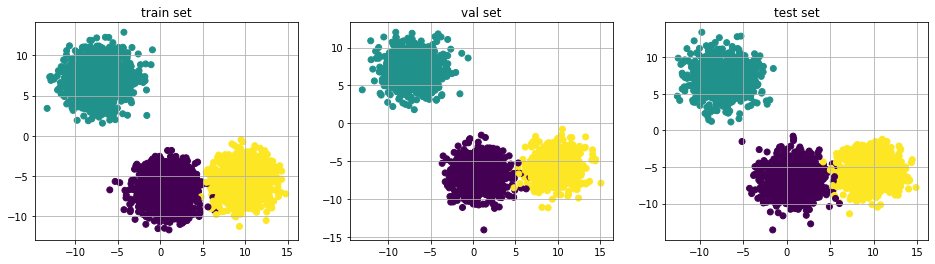

In [7]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],X_train[:,1],c=target_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],X_val[:,1],c=target_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],X_test[:,1],c=target_test)
ax2.set_title('test set')
ax2.grid()

In [8]:
logging.getLogger().setLevel(logging.DEBUG) 
InteractiveShell.ast_node_interactivity = 'all'

## SLP + MSQE + GD

(4489, 3) (2211, 3) (3300, 3)
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


(array([1470., 1509., 1510.]),
 array([746., 748., 717.]),
 array([1118., 1076., 1106.]))

100%|██████████| 20/20 [00:00<00:00, 390.21it/s, loss=0.737, lr=0.1]

(3, 3)


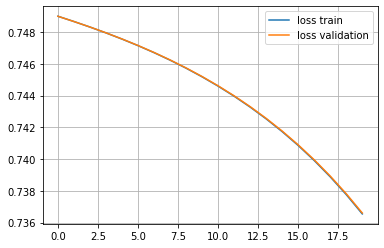

In [17]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {-1,+1}
# y_train, y_val, y_test = [ (y*2)-1 for y in [ y_train, y_val, y_test ] ]

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

y_train.sum(axis=0), y_val.sum(axis=0), y_test.sum(axis=0),

from lib.model.linear import SLP
# from lib.initiator.linear import NormalInitiatorLinearModel
from lib.initiator.linear import UniformInitiatorLinearModel

%xdel model

model = SLP(
    initiator=UniformInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
        high=.001,
    )
)

print(model.weight.shape)

from lib.loss.msqe import MSQE
loss_train = MSQE(model)
loss_val = MSQE(model)

from lib.optimizer.gd import GD 
from lib.optimizer.lrate import ConstLRA 
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери

lra = ConstLRA(.1)

model = GD( 
    loss=loss_train, 
    loss_val=loss_val, 
    lra=lra,
    breaker_val=[GrowthBreaking(),]
).fit( 
    data_train=[X_train,y_train], 
    data_val=[X_val,y_val], 
    n_epoch=20,
)

from lib.estimator.loss import LossPlot
LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

- - - - - - - - - - - - - - - - - - - - - -
all classes:
predict select argmax scores

              precision    recall  f1-score   support

           0       1.00      0.34      0.51      1118
           1       1.00      1.00      1.00      1076
           2       0.60      1.00      0.75      1106

    accuracy                           0.78      3300
   macro avg       0.87      0.78      0.75      3300
weighted avg       0.87      0.78      0.75      3300

- - - - - - - - - - - - - - - - - - - - - -

class 0:
score threshold:0.500502509763949

              precision    recall  f1-score   support

         0.0       0.49      0.49      0.49      2182
         1.0       0.01      0.01      0.01      1118

    accuracy                           0.33      3300
   macro avg       0.25      0.25      0.25      3300
weighted avg       0.33      0.33      0.33      3300

- - - - - - - - - - - - - - - - - - - - - -

class 1:
score threshold:0.5013588522222494

              precision   

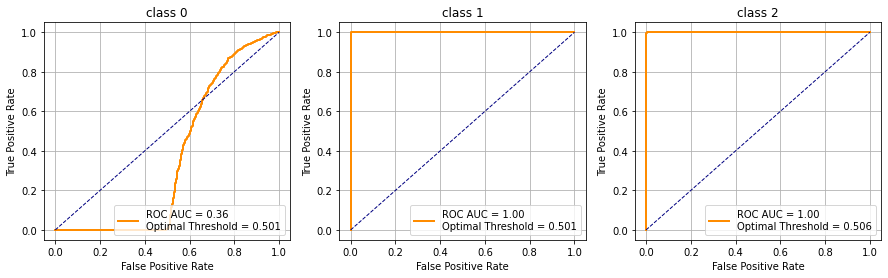

In [18]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,y_test)

## Softmax  + CCE + GD

In [19]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t] for t in [ target_train, target_val, target_test ] ]
# выход {0,+1}

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

y_train.sum(axis=0), y_val.sum(axis=0), y_test.sum(axis=0),

(4489, 3) (2211, 3) (3300, 3)
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


(array([1470., 1509., 1510.]),
 array([746., 748., 717.]),
 array([1118., 1076., 1106.]))

  2%|▏         | 2/100 [00:00<00:00, 99.43it/s, loss=0.974, lr=0.01]

(3, 3)
[INFO    ] 2021-10-04 15:17:54 | GrowthBreaking: significant increase in the loss function has been detected


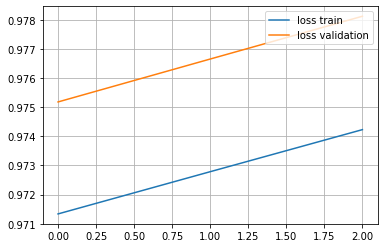

In [20]:
from lib.model.linear import Softmax 
from lib.initiator.linear import NormalInitiatorLinearModel
# from lib.initiator.linear import UniformInitiatorLinearModel

model = Softmax(
    # initiator=UniformInitiatorLinearModel(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
        scale=.1,
    )
)

print(model.weight.shape)

from lib.loss.cce import CCE # ф-ция потери - категориальная кросс-энтропия
loss_train = CCE(model)
loss_val = CCE(model)

from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
# from lib.optimizer.breaker import ThresholdBreaking # прерывание по достижению порога значения ф-ции потери
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери
# from lib.optimizer.breaker import DifferenceBreaking # прерывание при отсутствии изменения значения ф-ции потери

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.01),
    # breaker=[GrowthBreaking(),ThresholdBreaking(2.),DifferenceBreaking()]
    breaker_val=[GrowthBreaking(),]
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=100,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

- - - - - - - - - - - - - - - - - - - - - -
all classes:
predict select argmax scores

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1118
           1       0.73      0.97      0.83      1076
           2       0.25      0.22      0.24      1106

    accuracy                           0.39      3300
   macro avg       0.33      0.40      0.36      3300
weighted avg       0.32      0.39      0.35      3300

- - - - - - - - - - - - - - - - - - - - - -

class 0:
score threshold:0.3465949050019938

              precision    recall  f1-score   support

         0.0       0.48      0.46      0.47      2182
         1.0       0.02      0.02      0.02      1118

    accuracy                           0.31      3300
   macro avg       0.25      0.24      0.24      3300
weighted avg       0.32      0.31      0.32      3300

- - - - - - - - - - - - - - - - - - - - - -

class 1:
score threshold:0.4119737362692372

              precision  

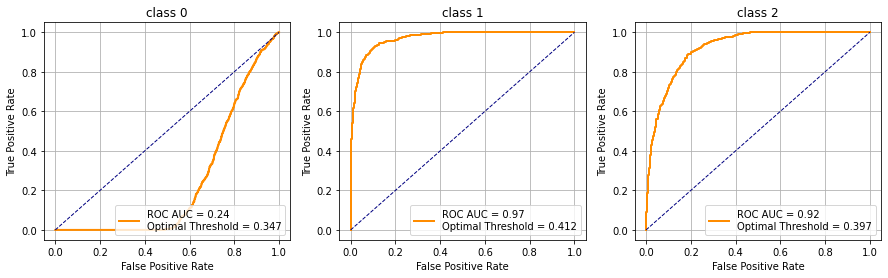

In [21]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,y_test)

## SPL_BPS + LogisticLoss + GD

In [22]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ np.eye(t.max()+1)[t]*2-1 for t in [ target_train, target_val, target_test ] ]
# выход {-1,+1}

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

(4489, 3) (2211, 3) (3300, 3)
[[-1. -1.  1.]
 [ 1. -1. -1.]
 [ 1. -1. -1.]]


  2%|▏         | 2/100 [00:00<00:00, 255.48it/s, loss=3.1, lr=0.01]

weight: (3, 3)
[INFO    ] 2021-10-04 15:18:07 | GrowthBreaking: significant increase in the loss function has been detected


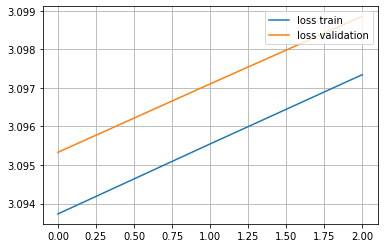

In [25]:
from lib.model.linear import SLP_BPS
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP_BPS(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=y_train.shape[1],
    )
)

print('weight:',model.weight.shape)

from lib.loss.logistic import LogisticLoss
loss_train = LogisticLoss(model)
loss_val = LogisticLoss(model)


# from lib.loss.binary.hinge import HingeLoss
# loss_train = HingeLoss(model)
# loss_val = HingeLoss(model)

from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
# from lib.optimizer.breaker import ThresholdBreaking # прерывание по достижению порога значения ф-ции потери
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери
# from lib.optimizer.breaker import DifferenceBreaking # прерывание при отсутствии изменения значения ф-ции потери

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.01),
    # breaker=[GrowthBreaking(),ThresholdBreaking(2.),DifferenceBreaking()]
    breaker_val=[GrowthBreaking(),]
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=100,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

- - - - - - - - - - - - - - - - - - - - - -
all classes:
predict select argmax scores

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1118
           1       0.00      0.00      0.00      1076
           2       0.01      0.01      0.01      1106

    accuracy                           0.00      3300
   macro avg       0.00      0.00      0.00      3300
weighted avg       0.00      0.00      0.00      3300

- - - - - - - - - - - - - - - - - - - - - -

class 0:
score threshold:0.14722836569013217

              precision    recall  f1-score   support

        -1.0       0.99      0.96      0.97      2182
         1.0       0.93      0.97      0.95      1118

    accuracy                           0.97      3300
   macro avg       0.96      0.97      0.96      3300
weighted avg       0.97      0.97      0.97      3300

- - - - - - - - - - - - - - - - - - - - - -

class 1:
score threshold:-0.11093325498779699

              precisio

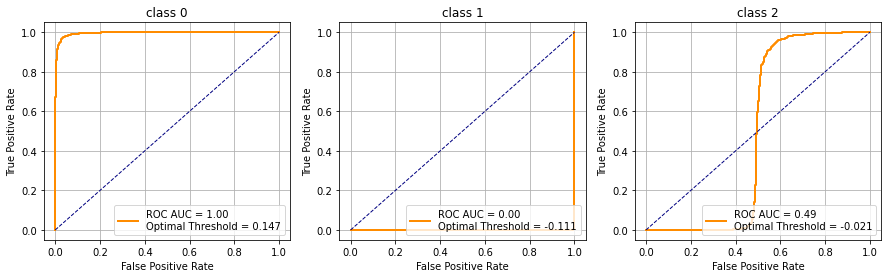

In [26]:
from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,y_test)